In [1]:
%matplotlib inline
import numpy as np
import pandas as pd 
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as linear_model
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from IPython.display import HTML, display

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

In [2]:
train = pd.read_csv('/Users/mathvan/Documents/anaconda/Kaggle/HousePrices/train.csv')
test = pd.read_csv('/Users/mathvan/Documents/anaconda/Kaggle/HousePrices/test.csv')

In [3]:
train.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5         Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
7         Lvl    AllPub  ...        0    NaN    NaN        Shed     350   
8         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
9         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

In [4]:
train.shape

(1460, 81)

In [5]:
numeric_features = [col for col in train.columns if train.dtypes[col] != 'object']
numeric_features.remove('SalePrice')
numeric_features.remove('Id')
categorical_features = [col for col in train.columns if train.dtypes[col] == 'object']

In [6]:
print(numeric_features[:5])
print(len(numeric_features))
print('-------')
print(categorical_features[:5])
print(len(categorical_features))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']
36
-------
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']
43


There are 1460 instances of training data and 1460 of test data. 
<br>Total number of attributes equals 81, of which 36 is quantitative, 43 categorical + Id and SalePrice.

<AxesSubplot:>

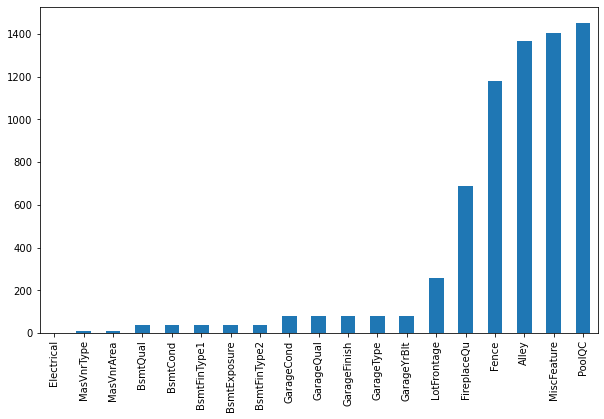

In [7]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
missing.plot.bar()

19 attributes have missing values, 5 over 50% of all data. Most of times NA means lack of subject described by attribute, like missing pool, fence, no garage and basement.

<AxesSubplot:title={'center':'Johnson SU'}, xlabel='SalePrice'>

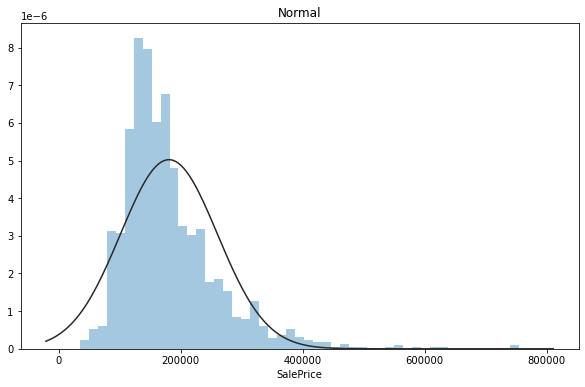

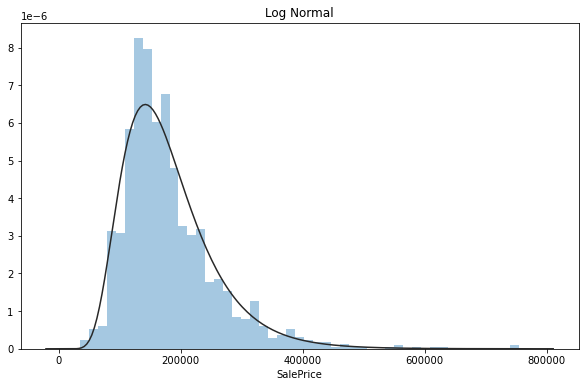

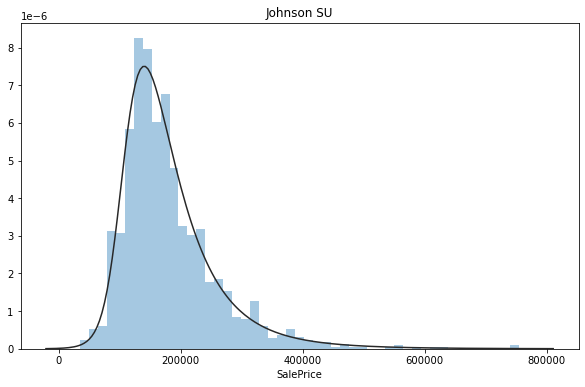

In [8]:
y = train['SalePrice']

fig, ax = plt.subplots(figsize=(10,6))
plt.figure(1); 
plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)

fig, ax = plt.subplots(figsize=(10,6))
plt.figure(2); 
plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

fig, ax = plt.subplots(figsize=(10,6))
plt.figure(3); 
plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)

It is apparent that SalePrice doesn't follow normal distribution, so before performing regression it has to be transformed. While log transformation does pretty good job, best fit is unbounded Johnson distribution.

In [9]:
test_normality = lambda x: st.shapiro( x.fillna(0) )[1] < 0.01
normal = pd.DataFrame(train[numeric_features])
normal = normal.apply(test_normality)

print(not normal.any())

False


Also none of quantitative variables has normal distribution so these should be transformed as well.

In [10]:
import warnings
warnings.filterwarnings("ignore")

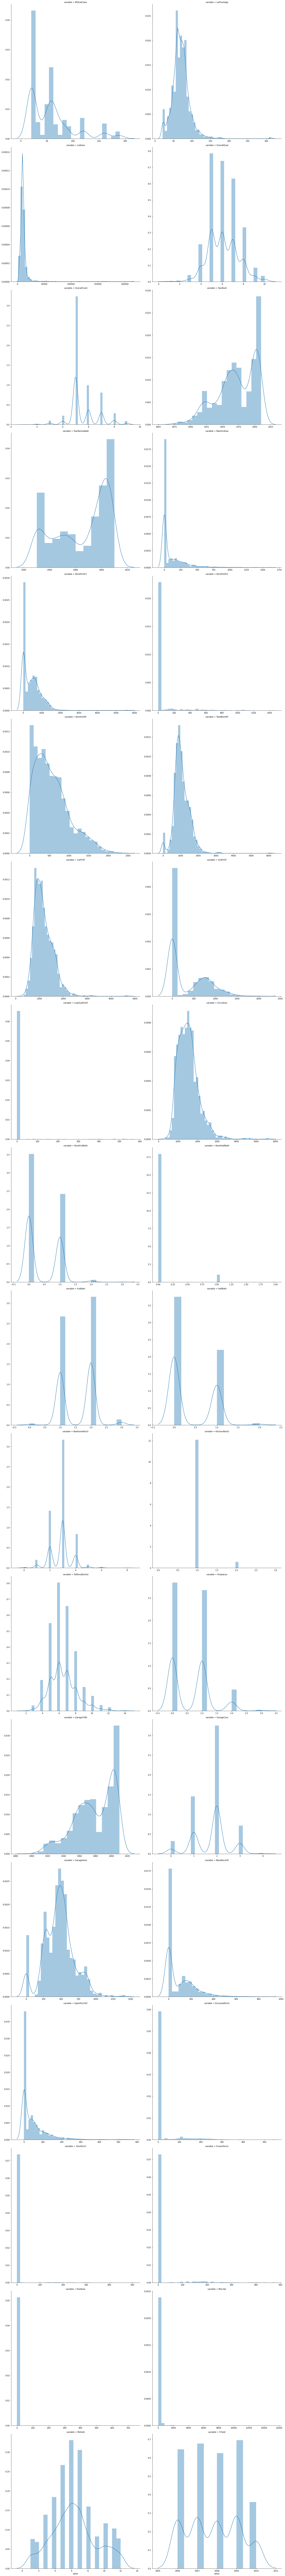

In [11]:
f = pd.melt(train, value_vars=numeric_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, height=10)
g = g.map(sns.distplot, "value")

Some independent variables look like good candidates for log transformation: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea and others. While ganining on regression transformation will smooth out some irregularities which could be important like large amount of houses with 0 2ndFlrSF. Such irregularities are good candidates for feature construction.

---

With qualitative (categorial) variables we can implement two methods. First one is to check distribution of SalePrice with respect to variable values and enumerate them. Second to create dummy variable for each possible category.

In [12]:
for c in categorical_features:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

In [13]:
def boxplot(x, y, **kwargs):
    
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)

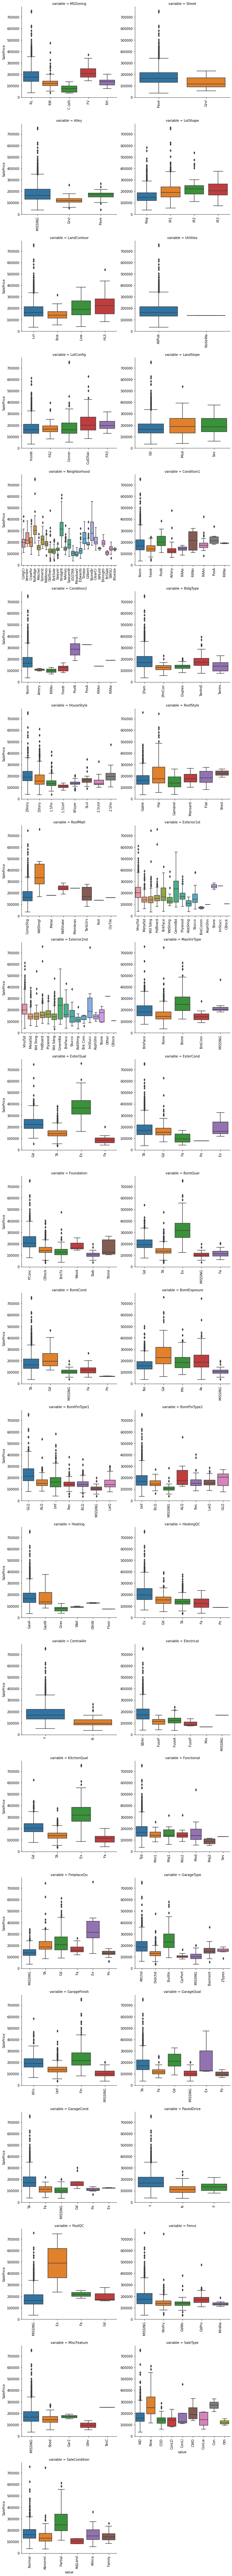

In [14]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=categorical_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")

In [15]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = categorical_features
    pvals = []
    
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
            
        pval = st.f_oneway(*samples)[1]
        pvals.append(pval)

    anv['pval'] = pvals
    
    return anv.sort_values('pval')

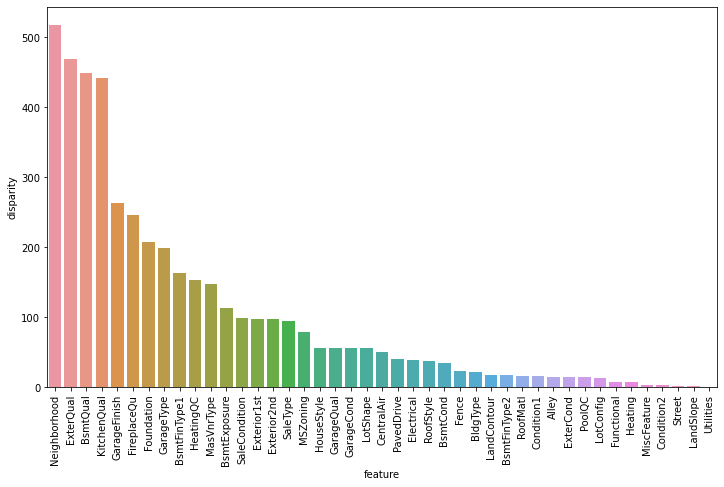

In [16]:
a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)

fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=a, x='feature', y='disparity')
plt.xticks(rotation=90);

Here is quick estimation of influence of categorical variable on SalePrice. For each variable SalePrices are partitioned to distinct sets based on category values. Then check with ANOVA test if sets have similar distributions. If variable has minor impact then set means should be equal. Decreasing pval is sign of increasing diversity in partitions.

In [17]:
def encode(frame, feature):
    
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [18]:
cat_encoded = []
for q in categorical_features:  
    encode(train, q)
    cat_encoded.append(q+'_E')
    
print(cat_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


Now categorial variables get encoded according to ordering based on mean of SalePrice.

---

In [19]:
def spearman(frame, features):
    
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    
    plt.figure(figsize=(7, 0.35*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

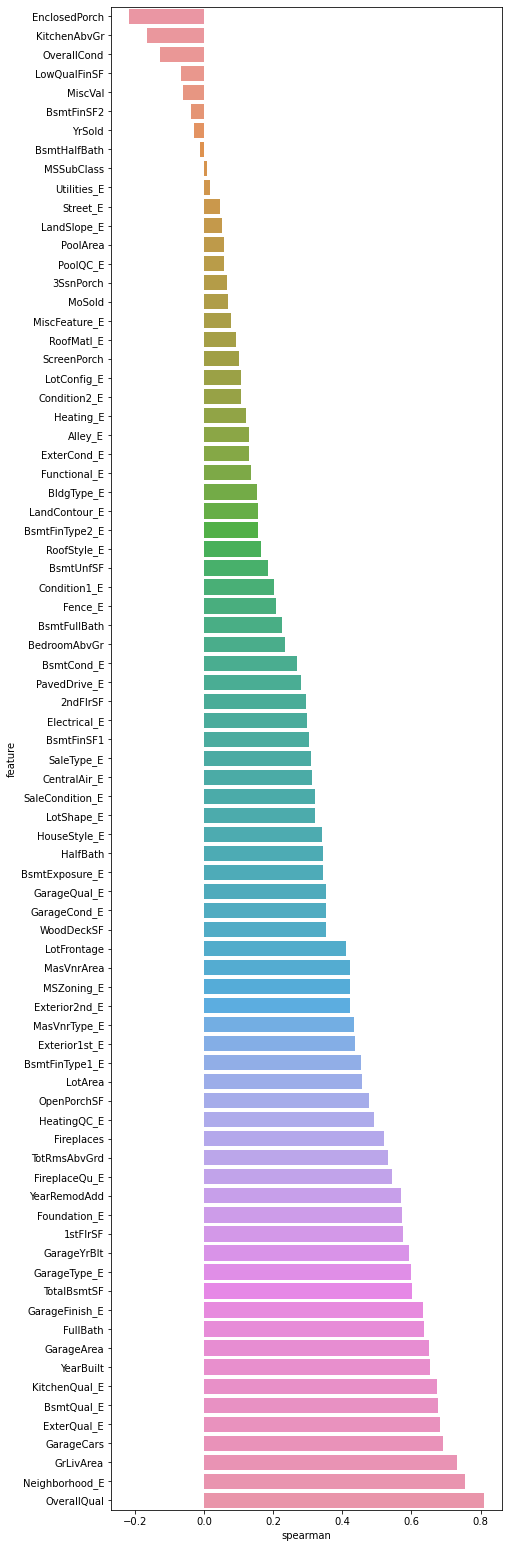

In [20]:
features = numeric_features + cat_encoded
spearman(train, features)

Spearman correlation is better to work with in this case because it picks up relationships between variables even when they are nonlinear. OverallQual is main criterion in establishing house price. Neighborhood has big influence, partially it has some intrisinc value in itself, but also houses in certain regions tend to share same characteristics (confunding) what causes similar valuations.

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

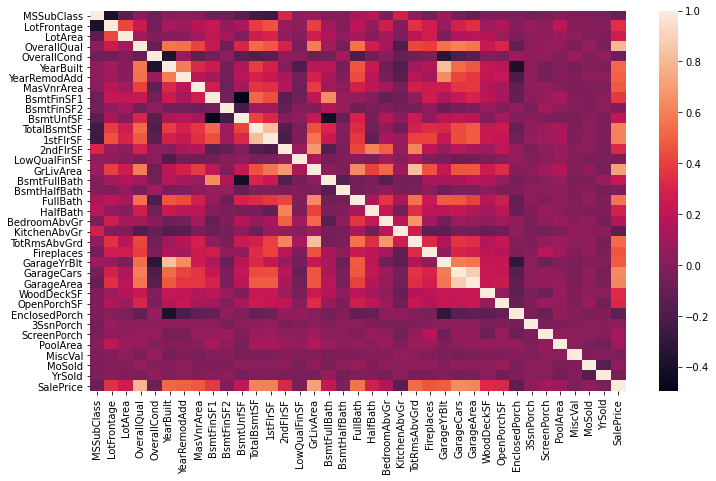

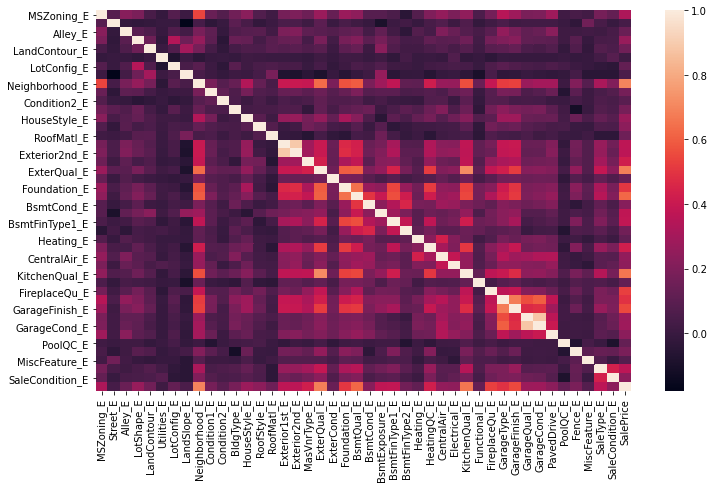

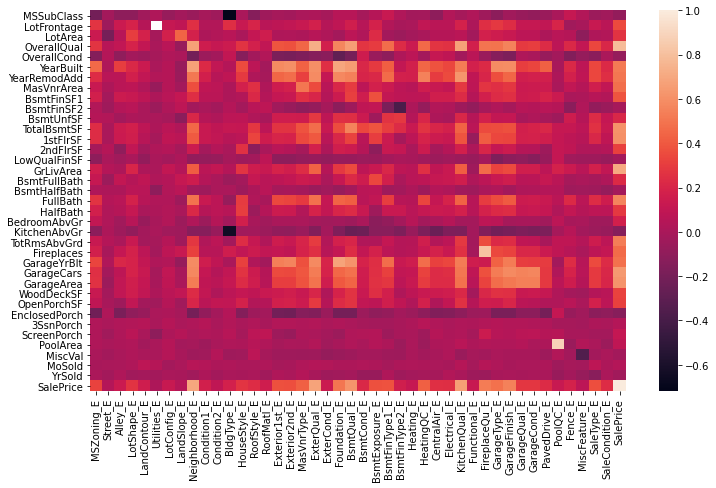

In [21]:
plt.figure(1)
fig, ax = plt.subplots(figsize=(12,7))
corr = train[numeric_features+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(2)
fig, ax = plt.subplots(figsize=(12,7))
corr = train[cat_encoded+['SalePrice']].corr()
sns.heatmap(corr)

plt.figure(3)
fig, ax = plt.subplots(figsize=(12,7))
corr = pd.DataFrame(np.zeros([len(numeric_features)+1, 
                              len(cat_encoded)+1]), 
                    index=numeric_features+['SalePrice'], 
                    columns=cat_encoded+['SalePrice'])
for q1 in numeric_features+['SalePrice']:
    for q2 in cat_encoded+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr)

There are many strong correlations between variables. Garages seem to be built same year as houses, basements have generally same area as first floor which is pretty obvious. Garage area is strongly correlated with number of cars. Neighborhood is correlated with lots of other variables and this confirms the idea that houses in same region share same characteristics. Dwelling type is negatively correlated with kitchen above grade square feet.

---

It also would be useful to see how sale price compares to each independent variable.

In [22]:
def pairplot(x, y, **kwargs):
    
    ts = pd.DataFrame({'time': x, 'val': y})
    ts = ts.groupby('time').mean()
    
    ax = plt.gca()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

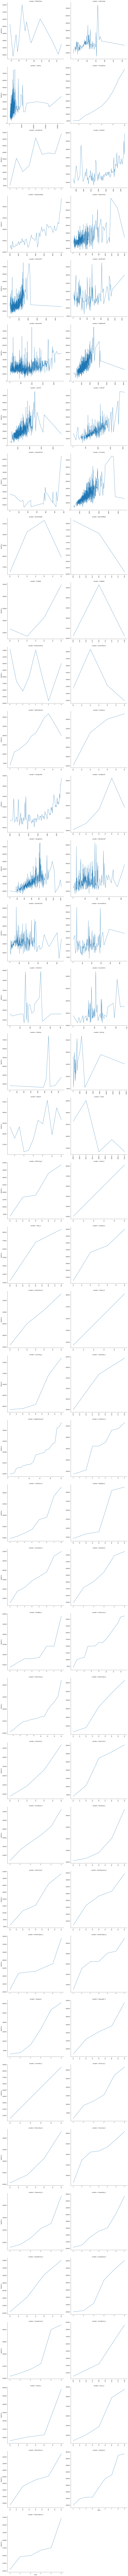

In [23]:
f = pd.melt(train, id_vars=['SalePrice'], value_vars=numeric_features+cat_encoded)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=8)
g = g.map(pairplot, "value", "SalePrice")

There are lots of nonlinearities this may be the cause why some variables wont be selected by Lasso/Lars. Some factors like YearBuilt, 1stFlrSF, 2ndFlrSF, Neighborhood_E look like they would benefit from adding quadratic term to regression. But on the other hand this will most probably provoke overfit.

---

It is possible that correlations shift with change of SalePrice.

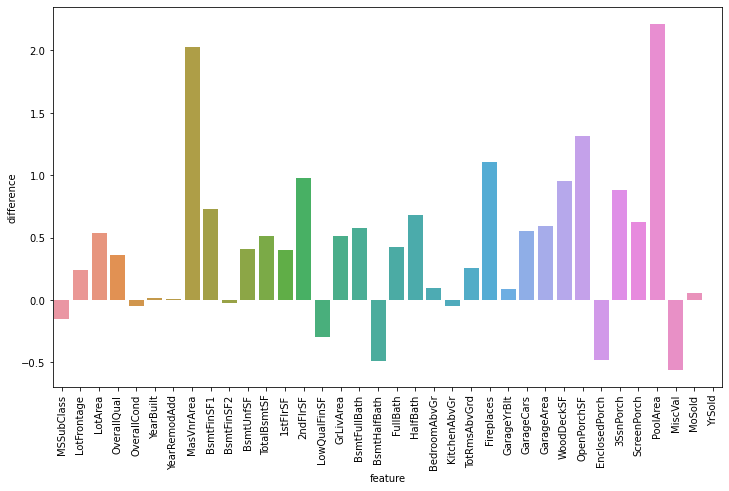

In [24]:
features = numeric_features

standard = train[train['SalePrice'] < 200000]
pricey = train[train['SalePrice'] >= 200000]

diff = pd.DataFrame()
diff['feature'] = features
diff['difference'] = [(pricey[f].fillna(0.).mean() - 
                           standard[f].fillna(0.).mean())
                           / (standard[f].fillna(0.).mean())
                      for f in features]

fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(data=diff, x='feature', y='difference')
x=plt.xticks(rotation=90)

Here houses are divided in two price groups: cheap (under 200000) and expensive. Then means of quantitative variables are compared. Expensive houses have pools, better overall qual and condition, open porch and increased importance of MasVnrArea.

In [25]:
features = numeric_features + cat_encoded

In [26]:
%%time
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = train[features].fillna(0.).values
tsne = model.fit_transform(X)

CPU times: user 46.4 s, sys: 2.16 s, total: 48.6 s
Wall time: 16.5 s


In [27]:
std = StandardScaler()
s = std.fit_transform(X)

pca = PCA(n_components=30)
pca.fit(s)
pc = pca.transform(s)

In [28]:
%%time
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

CPU times: user 493 ms, sys: 70.8 ms, total: 563 ms
Wall time: 309 ms


KMeans(n_clusters=5)

0.7499249190948322


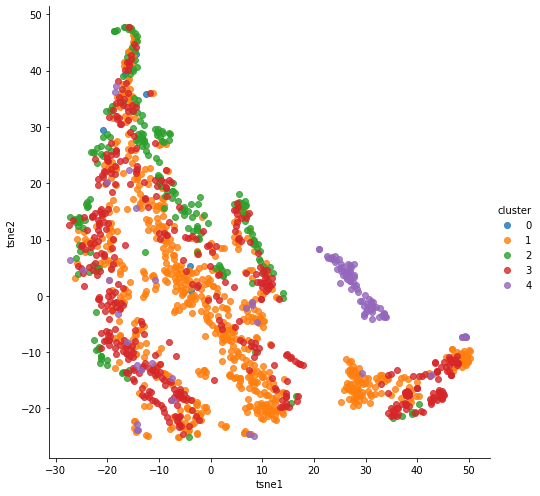

In [29]:
fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})

sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False, height=7)

print(np.sum(pca.explained_variance_ratio_))

30 First PCA Components explain 75% of variance. There seems to be some clustering present but it is not enough for segmented regression.

In [30]:
y = train['SalePrice'].values

In [31]:
def johnson(y):
    gamma, eta, epsilon, lbda = st.johnsonsu.fit(y)
    yt = gamma + eta*np.arcsinh((y-epsilon)/lbda)
    
    return yt, gamma, eta, epsilon, lbda

def johnson_inverse(y, gamma, eta, epsilon, lbda):
    
    return lbda*np.sinh((y-gamma)/eta) + epsilon

<AxesSubplot:>

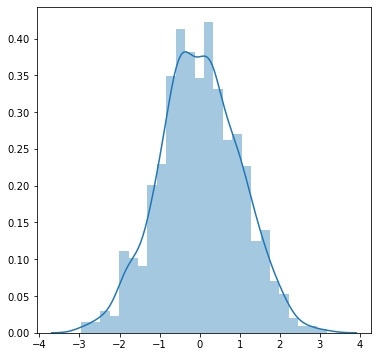

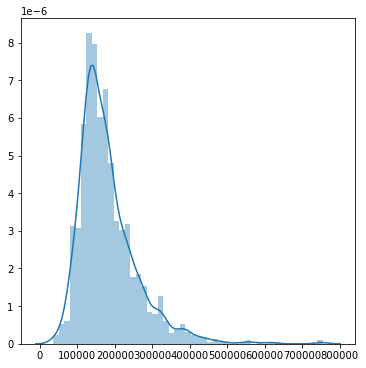

In [32]:
yt, g, et, ep, l = johnson(y)
yt2 = johnson_inverse(yt, g, et, ep, l)

fig, ax = plt.subplots(figsize=(6,6))
plt.figure(1)
sns.distplot(yt)

fig, ax = plt.subplots(figsize=(6,6))
plt.figure(2)
sns.distplot(yt2)

Here is Inverse Johnson Transform of SalePrice. Box Cox, Fisher and Johnson transforms can't beat log in simple linear regression. It is probably because they have tunable parameters that overfit to training data. If there were much more than 1500 instances they could be alternative to log transformation.

---

In [33]:
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def log_transform(feature):
    train[feature] = np.log1p(train[feature].values)

def quadratic(feature):
    train[feature+'2'] = train[feature]**2

In [34]:
log_transform('GrLivArea')
log_transform('1stFlrSF')
log_transform('2ndFlrSF')
log_transform('TotalBsmtSF')
log_transform('LotArea')
log_transform('LotFrontage')
log_transform('KitchenAbvGr')
log_transform('GarageArea')

quadratic('OverallQual')
quadratic('YearBuilt')
quadratic('YearRemodAdd')
quadratic('TotalBsmtSF')
quadratic('2ndFlrSF')
quadratic('Neighborhood_E')
quadratic('RoofMatl_E')
quadratic('GrLivArea')


qdr = ['OverallQual2', 'YearBuilt2', 'YearRemodAdd2', 'TotalBsmtSF2',
        '2ndFlrSF2', 'Neighborhood_E2', 'RoofMatl_E2', 'GrLivArea2']
boolean = ['HasBasement', 'HasGarage', 'Has2ndFloor', 'HasMasVnr', 'HasWoodDeck',
            'HasPorch', 'HasPool', 'IsNew']

features = numeric_features + cat_encoded + boolean + qdr

In [35]:
train['HasBasement'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasGarage'] = train['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train['Has2ndFloor'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasMasVnr'] = train['MasVnrArea'].apply(lambda x: 1 if x > 0 else 0)
train['HasWoodDeck'] = train['WoodDeckSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPorch'] = train['OpenPorchSF'].apply(lambda x: 1 if x > 0 else 0)
train['HasPool'] = train['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train['IsNew'] = train['YearBuilt'].apply(lambda x: 1 if x > 2000 else 0)

In [36]:
X = train[features].fillna(0.).values
Y = train['SalePrice'].values

In [37]:
lasso = linear_model.LassoLarsCV(max_iter=10000)
lasso.fit(X, np.log(Y))

LassoLarsCV(max_iter=10000)

In [38]:
Ypred = np.exp(lasso.predict(X))
error(Y, Ypred)

0.11194749395516307

Adding quadratic terms improves local score but behaves unstable on LB.

In [39]:
import patsy

In [40]:
Y, X = patsy.dmatrices(
    "SalePrice ~ \
        GarageCars + \
        np.log1p(BsmtFinSF1) + \
        ScreenPorch + \
        Condition1_E + \
        Condition2_E + \
        WoodDeckSF + \
        np.log1p(LotArea) + \
        Foundation_E + \
        MSZoning_E + \
        MasVnrType_E + \
        HouseStyle_E + \
        Fireplaces + \
        CentralAir_E + \
        BsmtFullBath + \
        EnclosedPorch + \
        PavedDrive_E + \
        ExterQual_E + \
        bs(OverallCond, df=7, degree=1) + \
        bs(MSSubClass, df=7, degree=1) + \
        bs(LotArea, df=2, degree=1) + \
        bs(FullBath, df=3, degree=1) + \
        bs(HalfBath, df=2, degree=1) + \
        bs(BsmtFullBath, df=3, degree=1) + \
        bs(TotRmsAbvGrd, df=2, degree=1) + \
        bs(LandSlope_E, df=2, degree=1) + \
        bs(LotConfig_E, df=2, degree=1) + \
        bs(SaleCondition_E, df=3, degree=1) + \
        OverallQual + np.square(OverallQual) + \
        GrLivArea + np.square(GrLivArea) + \
        Q('1stFlrSF') + np.square(Q('1stFlrSF')) + \
        Q('2ndFlrSF') + np.square(Q('2ndFlrSF')) +  \
        TotalBsmtSF + np.square(TotalBsmtSF) +  \
        KitchenAbvGr + np.square(KitchenAbvGr) +  \
        YearBuilt + np.square(YearBuilt) + \
        Neighborhood_E + np.square(Neighborhood_E) + \
        Neighborhood_E:OverallQual + \
        MSSubClass:BldgType_E + \
        ExterQual_E:OverallQual + \
        PoolArea:PoolQC_E + \
        Fireplaces:FireplaceQu_E + \
        OverallQual:KitchenQual_E + \
        GarageQual_E:GarageCond + \
        GarageArea:GarageCars + \
        Q('1stFlrSF'):TotalBsmtSF + \
        TotRmsAbvGrd:GrLivArea",
    train.to_dict('list'))

In [41]:
ridge = linear_model.RidgeCV(cv=10)
ridge.fit(X, np.log(Y))

Ypred = np.exp(ridge.predict(X))
print(error(Y,Ypred))

0.1160232072729066


This gives better local score, but on LB is ~12.6. However it looks that dividing some variables into splines gives some improvement.